In [5]:
import pathlib
import duckdb
import matplotlib.pyplot as plt

# Compounds in each assay

In [10]:
# Specify the directory
directory = pathlib.Path("/Users/sethhowes/Desktop/FS-Tox/data/processed")

# List all parquet files in the directory
parquet_files = [str(file) for file in directory.rglob('assay_*.parquet')]

# Create a connection to DuckDB
con = duckdb.connect()

row_counts = []

# For each parquet file, execute a SQL query to count the number of rows
for file in parquet_files:
    row_count = con.execute(f"SELECT COUNT(*) FROM parquet_scan('{file}', HIVE_PARTITIONING=true)").fetchall()[0][0]
    row_counts.append(row_count)

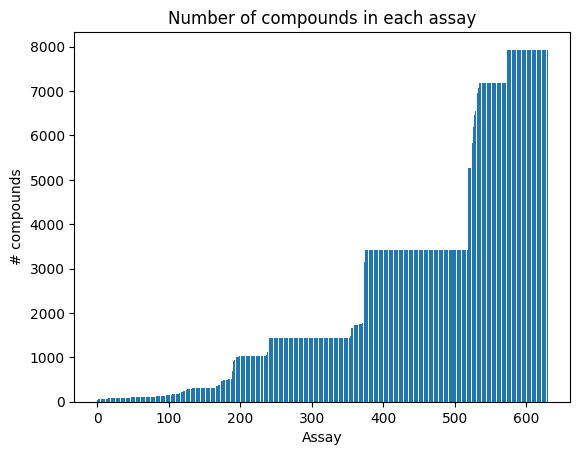

In [19]:
# sort the list in ascending order
row_counts.sort()

# create indices for x-axis
indices = range(len(row_counts))

# create a bar plot of the sorted numbers
plt.bar(indices, row_counts)
plt.title("Number of compounds in each assay")
plt.xlabel("Assay")
plt.ylabel("# compounds")

plt.show()

# Active compounds in each assay

In [6]:
# Specify the directory
directory = pathlib.Path("/Users/sethhowes/Desktop/FS-Tox/data/processed")

# List all parquet files in the directory
parquet_files = [str(file) for file in directory.rglob('assay_*.parquet')]

# Create a connection to DuckDB
con = duckdb.connect()

active_proportion = []

# For each parquet file, execute a SQL query to get the active proportion
for file in parquet_files:
    active_count = con.execute(f"SELECT SUM(ground_truth) FROM parquet_scan('{file}', HIVE_PARTITIONING=true)").fetchall()[0][0]
    total_count = con.execute(f"SELECT COUNT(*) FROM parquet_scan('{file}', HIVE_PARTITIONING=true)").fetchall()[0][0]
    active_proportion.append(active_count / total_count)

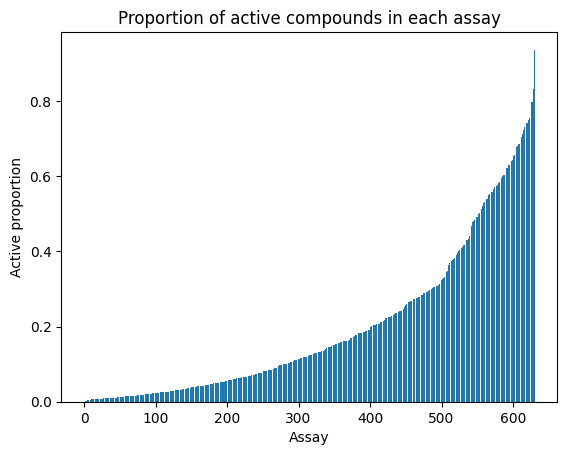

In [12]:
# sort the list in ascending order
active_proportion.sort()

# create indices for x-axis
indices = range(len(active_proportion))

# create a bar plot of the sorted numbers
plt.bar(indices, active_proportion)
plt.title("Proportion of active compounds in each assay")
plt.xlabel("Assay")
plt.ylabel("Proportion active")
plt.show()